In [1]:
# import pyspark modules
from pyspark import SparkContext
sc = SparkContext()

In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
# Linear-time selection

data = [34, 67, 21, 56, 47, 89, 12, 44, 74, 43, 26]
# 12 21 26 34 43 44 47 56 67 74 89

A = sc.parallelize(data,2) # slice = 2
# print(A.collect()）
k = 4 # find the element with index = 4 from small to big---> 43 (index begin from 0)

while True:
   
    x = A.first()
    
    A1 = A.filter(lambda z: z < x)
    A2 = A.filter(lambda z: z > x)
    
    mid = A1.count()
    if mid == k:
        print (x)
        break
    if k < mid:
        A = A1
    else:
        A = A2
        k = k - mid - 1
    # A.cache()

67


In [ ]:
# Import graphviz to draw digram
from graphviz import Digraph

要理解这个问题，首先要明白两个问题：
* 继承（也叫依赖）
* 重计算

我们在编程中常认为`=`运算是赋值的意思，但在RDD中这里面除了赋值，还有一层继承的关系，何为**继承**呢？我们先看下面一个简单的例子：
```
data = [2, 5, 9, 7, 8, 1, 3, 4]
x = 5
A = sc.parallelize(data,2)
A1 = A.filter(lambda z: z < x)
A2 = A.filter(lambda z: z > x)
```
A可以认为是一个父结点，它是一个RDD对象，在代码第4,5行，我们使用赋值语句时，会创建两个新的RDD对象，并且构建如下图的依赖关系，我们可以说A1, A2是从父结点A继承而来的。
```
A = [2,5,9,7,8,1,3,4] ---- |--(小于5)--> A1 = [2,1,3,4]
                           |--(大于5)--> A2 = [9,7,8]
```

我们再运行下面的语句，又会发生什么呢？
```
A = A2
```
如果按照我们以前编程的知识，是不是认为A只是被重新赋了值，即`A = [9,7,8]`。但在RDD中，这会新创建一个RDD对象，如下图所示：
```
A = [2,5,9,7,8,1,3,4] ----- |--(小于5)--> A1 = [2,1,3,4]
                            |--(大于5)--> A2 = [9,7,8] --(等于)--> A = [9,7,8]
```

如果我们再运行下面的代码，取出A中的第一个元素，这时会发生什么呢？这就要涉及到**重计算**的概念了。
```
x = A.first()
```
因为我们并没有运行`A.cache()`或`A.persist()`将A持久化，这就会导致在执行完`A.first()`得到`x = 9`后，还会按照上面的依赖关系从头到尾再计算一遍。由于`x`值的改变，会导致A1,A2发生变化，A1是小于9的集合，而A2变成了空集，进而导致A也变成了空集，但是最开始的那个父结点A并不受影响，虽然都是A但是是两个不同的RDD对象。
```
A = [2,5,9,7,8,1,3,4] ---- |--(小于9)--> A1 = [2,5,7,8,1,3,4]
                           |--(大于9)--> A2 = [] --(等于)--> A = []
```
我们回到真正的问题上，为什么不用`A.cache()`会导致最终的输出是`x=67`，我们画出在第一次循环执行完的RDD-依赖链式关系图：
```
A = [34,67,21,56,47,89,12,44,74,43,26] ---- |--(小于34)--> A1 = [21,12,26]
                                            |--(大于34)--> A2 = [67,56,47,89,44,74,43] 
                                                           |--(等于)--> A = [67,56,47,89,44,74,43]
```
由于没有运行`A.cache()`在第二次循环执行`A.first()`语句得到`x = 67`后，Spark在后面偷偷摸摸地重新计算，也就是
```
A = [34,67,21,56,47,89,12,44,74,43,26] ---- |--(小于67)--> A1 = [34,21,56,47,12,44,43,26]
                                            |--(大于67)--> A2 = [89,74] 
                                                           |--(等于)--> A = [89,74]
```
这时候运行下面的代码
```
A1 = A.filter(lambda z: z < x)
A2 = A.filter(lambda z: z > x)
```
会继续延展依赖关系，即
```
A = [34,67,21,56,47,89,12,44,74,43,26] ---- |--(小于67)--> A1 = [34,21,56,47,12,44,43,26]
                                            |--(大于67)--> A2 = [89,74] 
                                                           |--(等于)--> A = [89,74]
                                                                        |--(小于67)--> A1 = []
                                                                        |--(大于67)--> A2 = [89,74] 
                                                                                     |--(等于)--> A = [89,74]
```
这时的`mid = A1.count()`应该会得到`0`等于k，所以输出`x = 67`

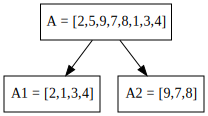

In [21]:
lineage = Digraph(name='Lineage',, node_attr={'shape': 'box'})


lineage.node('A', 'A = [2,5,9,7,8,1,3,4]')
lineage.node('B', 'A1 = [2,1,3,4]')
lineage.node('C', 'A2 = [9,7,8]')
lineage.edges(['AB', 'AC'])
lineage